In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
image_size = (224, 244)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Elbrus/Skin Cancer Malignant vs. Benign/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Elbrus/Skin Cancer Malignant vs. Benign/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.
Found 660 files belonging to 2 classes.
Using 132 files for validation.


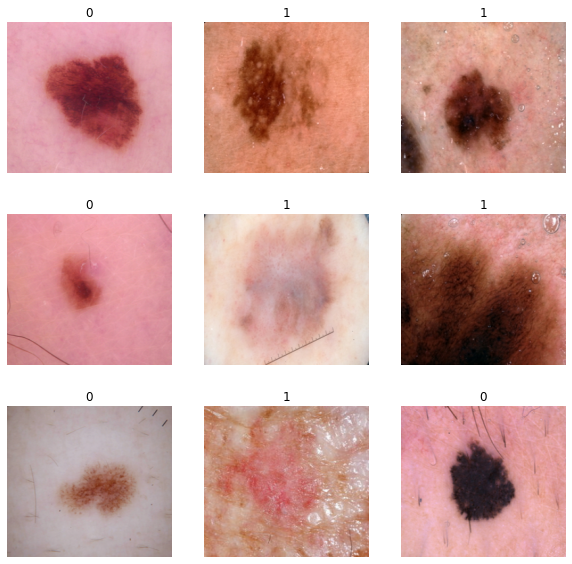

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

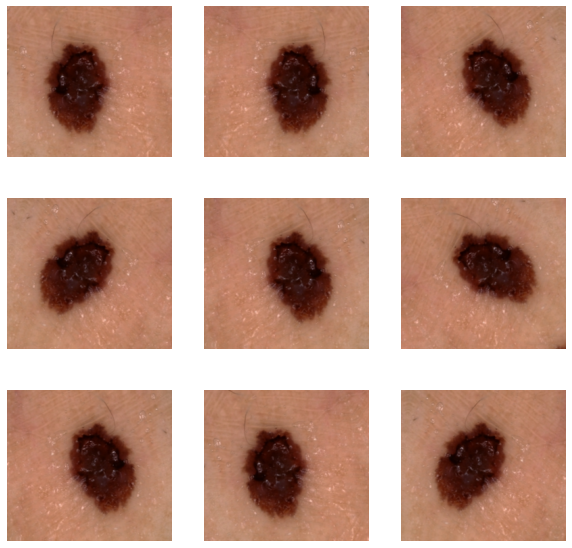

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

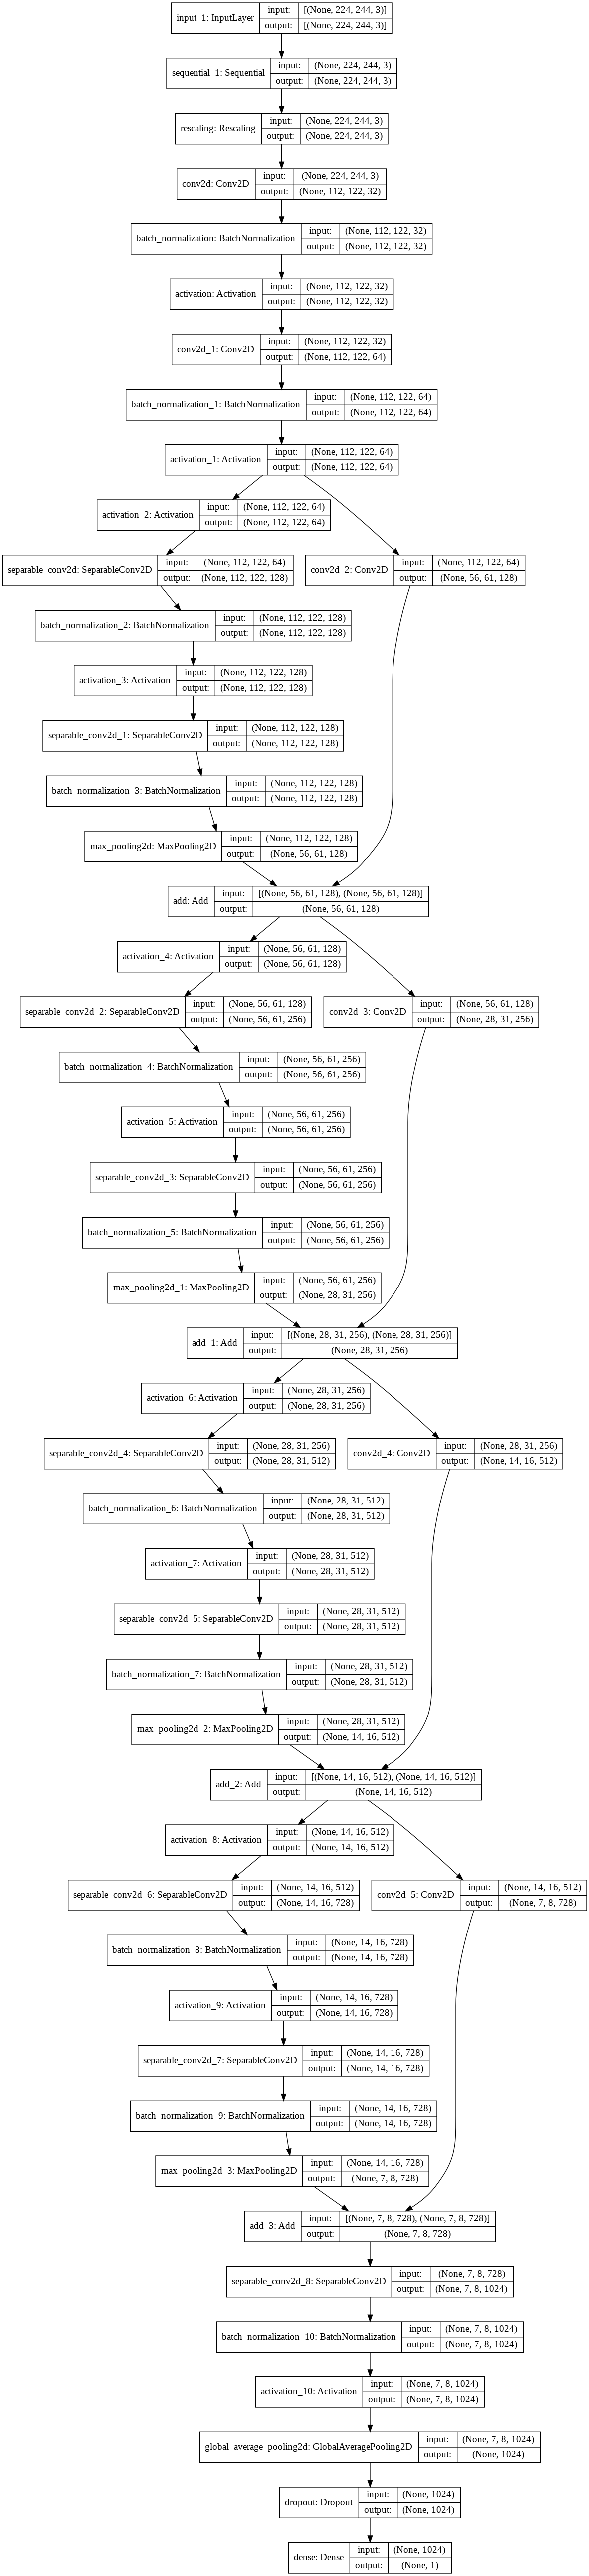

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
66/66 [==============================] - 335s 5s/step - loss: 0.5297 - accuracy: 0.7555 - val_loss: 0.7402 - val_accuracy: 0.5000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
66/66 [==============================] - 30s 446ms/step - loss: 0.4191 - accuracy: 0.7967 - val_loss: 1.0058 - val_accuracy: 0.5000
Epoch 3/50
66/66 [==============================] - 30s 451ms/step - loss: 0.4070 - accuracy: 0.8019 - val_loss: 1.2890 - val_accuracy: 0.5000
Epoch 4/50
66/66 [==============================] - 31s 458ms/step - loss: 0.3999 - accuracy: 0.8071 - val_loss: 1.5457 - val_accuracy: 0.5000
Epoch 5/50
66/66 [==============================] - 31s 457ms/step - loss: 0.3580 - accuracy: 0.8341 - val_loss: 1.7727 - val_accuracy: 0.5000
Epoch 6/50
66/66 [==============================] - 30s 452ms/step - loss: 0.3627 - accuracy: 0.8336 - val_loss: 1.5554 - val_accuracy: 0.5000
Epoch 7/50
66/66 [==============================] - 31s 456ms/step - loss: 0.3487 - accuracy: 0.8346 - val_loss: 1.8706 - val_accuracy: 0.5000
Epoch 8/50
66/66 [==============================] - 31s 456ms/step - loss: 0.3640 - accuracy: 0.8289 - val_loss: 1.1087 - val_accuracy: 0.5152

In [20]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Elbrus/Skin Cancer Malignant vs. Benign/test/benign/1023.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent benign and %.2f percent maliognant"
    % (100 * (1 - score), 100 * score)
)

This image is 97.06 percent benign and 2.94 percent maliognant
